TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color.

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc.

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

In [9]:
import cv2
import numpy as np

tipo_de_moneda = ["2e", "1e", "50c", "20c", "10c", "5c", "2c", "1c"]
proporciones_originales = [1.11, 1, 1.04, 0.96, 0.85, 0.91, 0.81, 0.7]

valores_euros = {
    "2e": 2.00, "1e": 1.00, "50c": 0.50, "20c": 0.20,
    "10c": 0.10, "5c": 0.05, "2c": 0.02, "1c": 0.01
}


def lista_proporcional(tipo):
    pos = tipo_de_moneda.index(tipo)
    valor = proporciones_originales[pos]
    return [i / valor for i in proporciones_originales]

def hallar_valor(diametro_ref, diametro_nuevo, proporciones):
    proporcion_calculada = diametro_nuevo / diametro_ref
    mejor_dif = float('inf')
    pos = 0
    for i, propor in enumerate(proporciones):
        dif = abs(proporcion_calculada - propor)
        if dif < mejor_dif:
            mejor_dif = dif
            pos = i
    return tipo_de_moneda[pos]

def calcular_diametro(cnt):
    (x, y), radius = cv2.minEnclosingCircle(cnt)
    return radius * 2



img = cv2.imread('Monedas.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7, 7), 0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)


contornos, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contornos_filtrados = [c for c in contornos if 10000 < cv2.contourArea(c) < 200000]


centros = []
contornos_finales = []
for c in contornos_filtrados:
    (x, y), _ = cv2.minEnclosingCircle(c)
    centro = np.array([x, y])
    if all(np.linalg.norm(centro - np.array(p)) > 30 for p in centros):
        contornos_finales.append(c)
        centros.append(centro)

contornos = contornos_finales
print(f"Contornos finales: {len(contornos)}")


output = img.copy()
monedas_asignadas = {}
ref_diametro = None
proporciones = lista_proporcional("1c")

for i, c in enumerate(contornos):
    (x, y), _ = cv2.minEnclosingCircle(c)
    cv2.putText(output, str(i), (int(x) - 10, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    cv2.drawContours(output, [c], -1, (0, 255, 0), 2)

cv2.namedWindow("Monedas")
cv2.imshow("Monedas", output)


def click_event(event, x, y, flags, param):
    global ref_diametro, monedas_asignadas, output

    if event == cv2.EVENT_LBUTTONDOWN:
        for i, contorno in enumerate(contornos):
            if cv2.pointPolygonTest(contorno, (x, y), False) >= 0:
                print(f"\nClick sobre moneda #{i}")

                tipo = input(f"Tipo de moneda ({', '.join(tipo_de_moneda)}): ").strip()
                if tipo not in tipo_de_moneda:
                    print("Moneda no válida.")
                    return

                ref_diametro = calcular_diametro(contorno)
                print(f"Referencia: {tipo}, diámetro = {ref_diametro:.2f}px")

                proporciones_ref = lista_proporcional(tipo)
                monedas_asignadas.clear()
                output = img.copy()

                for j, c in enumerate(contornos):
                    diam = calcular_diametro(c)
                    tipo_estimado = hallar_valor(ref_diametro, diam, proporciones_ref)
                    monedas_asignadas[j] = tipo_estimado

                    M = cv2.moments(c)
                    if M["m00"] != 0:
                        cx = int(M["m10"] / M["m00"])
                        cy = int(M["m01"] / M["m00"])
                        cv2.putText(output, tipo_estimado, (cx - 25, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                        cv2.drawContours(output, [c], -1, (0, 255, 0), 2)

                contar_monedas_y_valor()
                cv2.imshow("Monedas", output)
                break

def contar_monedas_y_valor():
    conteo = {}
    total = 0
    for tipo in monedas_asignadas.values():
        conteo[tipo] = conteo.get(tipo, 0) + 1
        total += valores_euros[tipo]

    print("\n--- RESULTADOS ---")
    for tipo, cantidad in conteo.items():
        print(f"{tipo}: {cantidad} moneda(s)")
    print(f"Total estimado: {total:.2f} €")

cv2.setMouseCallback("Monedas", click_event)


while True:
    key = cv2.waitKey(1) & 0xFF
    if key == 27:
        break

cv2.destroyAllWindows()


print("\nMonedas identificadas:")
for idx, tipo in monedas_asignadas.items():
    print(f"Moneda #{idx}: {tipo}")


Contornos finales: 8

Click sobre moneda #7
Referencia: 2e, diámetro = 211.25px

--- RESULTADOS ---
1c: 1 moneda(s)
20c: 1 moneda(s)
2c: 1 moneda(s)
50c: 1 moneda(s)
10c: 1 moneda(s)
1e: 1 moneda(s)
5c: 1 moneda(s)
2e: 1 moneda(s)
Total estimado: 3.88 €

Monedas identificadas:
Moneda #0: 1c
Moneda #1: 20c
Moneda #2: 2c
Moneda #3: 50c
Moneda #4: 10c
Moneda #5: 1e
Moneda #6: 5c
Moneda #7: 2e


TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y aprender patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test MPs_test.jpg y sus correpondientes anotaciones MPs_test_bbs.csv con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases

In [31]:
import cv2
import numpy as np

def calcular_medias_contornos(contornos, area_min):
    if len(contornos) == 0:
        return (0, 0, 0, 0, 0)

    suma_area = suma_perimetro = suma_comp = suma_AR = suma_solidez = suma_intensidad = 0
    contador_validos = 0

    for cnt in contornos:
        area = cv2.contourArea(cnt)
        if area > area_min:
            perimetro = cv2.arcLength(cnt, True)
            compacidad = (perimetro ** 2) / (4 * np.pi * area) if area > 0 else 0

            x, y, w, h = cv2.boundingRect(cnt)
            AR = w / h if h > 0 else 0

            hull = cv2.convexHull(cnt)
            hull_area = cv2.contourArea(hull)
            solidez = area / hull_area if hull_area > 0 else 0
            mask_contour = np.zeros(img_gris.shape, np.uint8)
            cv2.drawContours(mask_contour, [cnt], -1, 255, -1)
            media_color = cv2.mean(img_gris, mask=mask_contour)[0]  
            suma_area += area
            suma_perimetro += perimetro
            suma_comp += compacidad
            suma_AR += AR
            suma_solidez += solidez
            suma_intensidad += media_color
            contador_validos += 1
            

    if contador_validos == 0:
        contador_validos = 1
    return (
        suma_area / contador_validos,
        suma_perimetro / contador_validos,
        suma_comp / contador_validos,
        suma_AR / contador_validos,
        suma_solidez / contador_validos,
        suma_intensidad / contador_validos
    )


img_fragments = cv2.imread("FRA.png")
img_pellets = cv2.imread("PEL.png")
img_tar = cv2.imread("TAR.png")


# Obtención datos fragmentos
img_gris = cv2.cvtColor(img_fragments, cv2.COLOR_BGR2GRAY)
_, img_th2 = cv2.threshold(img_gris, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contornos, _ = cv2.findContours(img_th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
area_media_frag, perimetro_media_frag, compacidad_media_frag, AR_media_frag, solidez_media_frag, intensidad_media_frag = calcular_medias_contornos(contornos, 100)


# Obtención datos pellets
img_gris = cv2.cvtColor(img_pellets, cv2.COLOR_BGR2GRAY)
_, img_th2 = cv2.threshold(img_gris, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contornos, _ = cv2.findContours(img_th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
area_media_pellets, perimetro_media_pellets, compacidad_media_pellets, AR_media_pellets, solidez_media_pellets, intensidad_media_pellets = calcular_medias_contornos(contornos, 100)


# Obtención datos tar
img_gris = cv2.cvtColor(img_tar, cv2.COLOR_BGR2GRAY)
_, img_th2 = cv2.threshold(img_gris, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contornos, _ = cv2.findContours(img_th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
area_media_tar, perimetro_media_tar, compacidad_media_tar, AR_media_tar, solidez_media_tar, intensidad_media_tar = calcular_medias_contornos(contornos, 100)


# Resultados
print("Medias")
print(f"FRAG  -> Área: {area_media_frag:.2f}, Compacidad: {compacidad_media_frag:.2f}, AR: {AR_media_frag:.2f}, Solidez: {solidez_media_frag:.2f}, Intensidad: {intensidad_media_frag:.2f}")
print(f"PEL   -> Área: {area_media_pellets:.2f}, Compacidad: {compacidad_media_pellets:.2f}, AR: {AR_media_pellets:.2f}, Solidez: {solidez_media_pellets:.2f},  Intensidad: {intensidad_media_pellets:.2f}")
print(f"TAR   -> Área: {area_media_tar:.2f}, Compacidad: {compacidad_media_tar:.2f}, AR: {AR_media_tar:.2f}, Solidez: {solidez_media_tar:.2f},  Intensidad: {intensidad_media_tar:.2f}")


Medias
FRAG  -> Área: 3702.50, Compacidad: 4.14, AR: 1.59, Solidez: 0.77, Intensidad: 112.34
PEL   -> Área: 4287.85, Compacidad: 1.23, AR: 1.03, Solidez: 0.98,  Intensidad: 68.25
TAR   -> Área: 2989.44, Compacidad: 1.38, AR: 1.04, Solidez: 0.95,  Intensidad: 28.69


Datos cargados:
  label  x_min  y_min  x_max  y_max
0   TAR    503   1171    532   1186
1   TAR    204   1103    244   1133
2   TAR     16   1086     44   1118
3   TAR    524   1022    545   1048
4   TAR    408    975    433    997

===== MÉTRICAS =====
Accuracy: 0.35051546391752575
Precision: 0.1992159140409467
Recall: 0.35051546391752575
F1: 0.24113892979872364


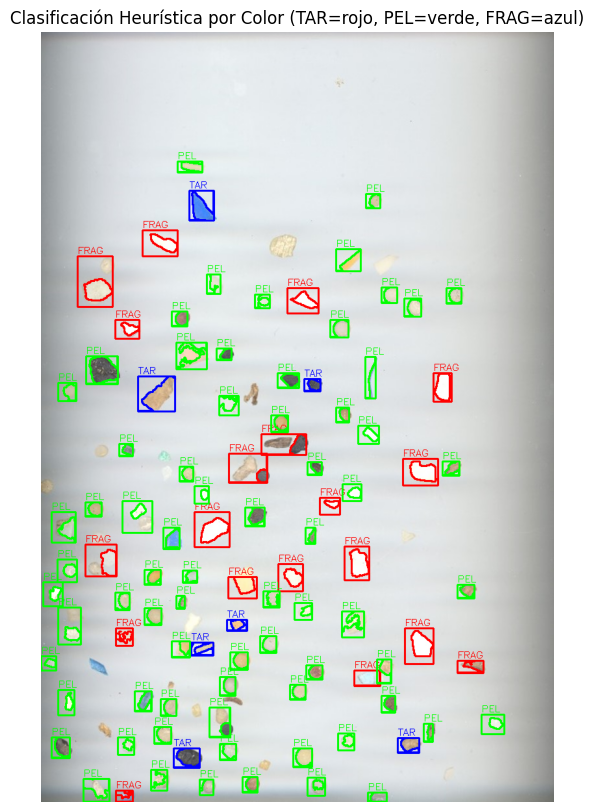

In [ ]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

#Cargar imágenes y csv
csv_path = "MPs_test_bbs.csv"
bbs = pd.read_csv(csv_path)
print("Datos cargados:")
print(bbs.head())

img = cv2.imread("MPs_test.jpg")
img_draw = img.copy()

features = []

#Vamos revisando las coordenadas del csv para tratar los fragmentos de la imagen
for i, row in bbs.iterrows():
    x_min, y_min, x_max, y_max = map(int, [row["x_min"], row["y_min"], row["x_max"], row["y_max"]])
    #Guardamos su clase real
    true_class = row["label"]

    x_min = max(0, x_min); y_min = max(0, y_min)
    x_max = min(img.shape[1]-1, x_max); y_max = min(img.shape[0]-1, y_max)
    if x_max <= x_min or y_max <= y_min:
        continue

    #Obtengo un recorte de la imagen que luego paso a escala de grises  
    recorte = img[y_min:y_max, x_min:x_max]
    gray = cv2.cvtColor(recorte, cv2.COLOR_BGR2GRAY)
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)


    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        continue

    cnt = max(contours, key=cv2.contourArea)
    #Traduce las coordenadas del recorte a la imagen original
    cnt_global = cnt + np.array([[x_min, y_min]])

    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    #Calcula como de irregular es la forma, 1 = círculo perfecto, 1> irregular.
    compacidad = (perimeter ** 2) / (4 * np.pi * area) if area > 0 else 0
    x2, y2, w2, h2 = cv2.boundingRect(cnt)
    #Comprueba como de alargado (>1) o cuadrado (~1) es el objeto
    AR = w2 / h2 if h2 > 0 else 0
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 0
    mask_contour = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask_contour, [cnt], -1, 255, -1)
    media_color = cv2.mean(gray, mask=mask_contour)[0] 

    #Guardar todas las características de cada elemento 
    # del CSV que se ha buscado en la imagen
    features.append({
        "area": area,
        "perimeter": perimeter,
        "compacidad": compacidad,
        "AR": AR,
        "solidity": solidity,
        "intensity": media_color,
        "true_class": true_class,
        "bbox": (x_min, y_min, x_max, y_max),
        "contour": cnt_global
    })


df = pd.DataFrame(features)


#Clasificador heurístico
def clasificar(f):
    area = f["area"]
    comp = f["compacidad"]
    AR = f["AR"]
    sol = f["solidity"]
    intensity = f["intensity"]

    if area < 400 and AR < 1.3 or comp > 7.5:
        return "PEL"
    elif sol < 0.6 and comp>= 3:
        return "TAR"
    elif sol > 0.7 and area > 400 and comp < 2 or AR > 1.3:
        return "FRAG"

    else:
        return "PEL"


if not df.empty:
    df["pred_class"] = df.apply(clasificar, axis=1)

    color_dict = {"TAR": (255, 0, 0), "PEL": (0, 255, 0), "FRAG": (0, 0, 255) }
    #Dibujar cajas y escribir caja que ha predicho
    for _, row in df.iterrows():
        x_min, y_min, x_max, y_max = row["bbox"]
        color = color_dict.get(row["pred_class"], (255, 255, 255))
        cv2.rectangle(img_draw, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.drawContours(img_draw, [row["contour"]], -1, color, 2)
        cv2.putText(img_draw, row["pred_class"], (x_min, max(y_min-4, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    y_true = df["true_class"]
    y_pred = df["pred_class"]

    print("\n===== MÉTRICAS =====")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average="weighted", zero_division=0))
    print("Recall:", recall_score(y_true, y_pred, average="weighted", zero_division=0))
    print("F1:", f1_score(y_true, y_pred, average="weighted", zero_division=0))

img_show = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_show)
plt.axis("off")
plt.title("Clasificación Heurística por Color (TAR=rojo, PEL=verde, FRAG=azul)")
plt.show()
